# Fabi's crypto analysis



Analyzis and visualisation of the top 5 highest cryptos, from 2018 to 4.5.2021:

* Ethereum (ETH)
* Bitcoin (BTC)
* Polkadot (DOT)
* Cardano (ADA)
* Ripple (XRP).

Using Pandas, Pandas-Datarader, nd Matplotlib, Python

### 1. Import Packages

#### Step 1: Import Packages
Import the pandas and numpy module as `pd` and `np`, respectively

In [20]:
import pandas as pd
import numpy as np
#import the module
import pandas_datareader as web
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from IPython.display import display, HTML
import datetime
import requests
import json
from IPython.core.display import HTML


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 95)



%%html
 <style>
    @media print { 
    div.input {
      display: none;
      padding: 0;
    }    div.output_prompt {
      display: none;
      padding: 0;
    }    div.text_cell_render {
      padding: 1pt;
    }    div#notebook p,
    div#notebook,
    div#notebook li,
    p {
      font-size: 11pt;
      line-height: 135%;
      margin: 0;
    }    .rendered_html h1,
    .rendered_html h1:first-child {
      font-size: 16pt;
      margin: 7pt 0;
    }    .rendered_html h2,
    .rendered_html h2:first-child {
      font-size: 14pt;
      margin: 6pt 0;
    }    .rendered_html h3,
    .rendered_html h3:first-child {
      font-size: 13pt;
      margin: 6pt 0;
    }    div.output_subarea {
      padding: 0;
    }
  }  @page {
      size: A4;
  }
  </style>

### 2. Load the adjusted closings for the top 5 cryptos

#### Step 1: Define Scope
Create dictionaries for monthly and daily returns.
#### Step 2: Read CSV Data
Read Data and drop unnecessary cols(info)
#### Step 3: Calculate daily returns and create a new dataframe with monthly returns
log returns for future use
#### Step 4: View Data and return
View both `stock_data` and `stock_data['Adj Close']`. What information is stored in these DataFrames?

In [2]:
def download_stock_data(params=['MSFT',"2017-01-01",datetime.date.today()]):
    #symbols = ["MSFT", "AMZN", "AAPL", "GOOG", "FB"]
    stock_data = web.get_data_yahoo(*params)
  #  display(params[0],stock_data)
    stock_data.to_csv("{0}_Day_History.csv".format(*params), index=True)
    print('csvsaved'.format(*params))
    
def download_coin_data(params = ['BTC','EUR','2017-01-01',datetime.date.today()]):
        api_key = "8F74C89E-AF2E-4509-9914-A67EC30542E0"
        print('params',params)

        url = "https://rest.coinapi.io/v1/ohlcv/{0}/{1}/history?period_id=1DAY&time_start={2}T00:00:00&time_end={3}T23:59:00&limit=100000".format(*params)
        headers = {"X-CoinAPI-Key": api_key}
        response = requests.get(url, headers=headers)

        if (response.status_code == 429):
            # API response
            print("Too many requests.")
        else:
    # Get the information from the API
            coin_data = json.loads(response.text)
    # Assign information to a DataFrame for later use
            coin_pd_data = pd.DataFrame(coin_data) 
    # Create a CSV file with the values so not to waste the free daily API calls

            coin_pd_data.to_csv("{0}_Day_History.csv".format(*params), index=False)
            print('csvsaved'.format(*params))
    
def download_data(coins,stocks,start='2017-01-01',end=datetime.date.today()):
    for coin in coins: download_coin_data([coin,'USD',start,end])
    for stock in stocks: download_stock_data([stock,start,end])

download_data(['BTC','ETH','XRP'],['LHA.DE','AAPL','AMZN','FB','GOOGL'])  


params ['BTC', 'USD', '2017-01-01', datetime.date(2021, 6, 10)]
csvsaved
params ['ETH', 'USD', '2017-01-01', datetime.date(2021, 6, 10)]
csvsaved
params ['XRP', 'USD', '2017-01-01', datetime.date(2021, 6, 10)]
csvsaved
csvsaved
csvsaved
csvsaved
csvsaved
csvsaved


In [3]:
def replace_nan_values(incomplete_df,complete_df):
    #busniness month ende wirft bei einigen stocks NAN aus - schlecht für Vergleiche
    missings = incomplete_df[incomplete_df.isna().any(axis=1)]     
    new_df = complete_df.append(missings)
    new_df.sort_index(inplace=True)
    new_df['price'].fillna(value=new_df['price'].shift(1), inplace=True)
 #   print(new_df.loc[datetime.datetime(2020,12,29)])
 #   display(new_df)
    return new_df
    

def get_and_prepare_data(coins='',stocks='',start_after='2020'):
    #erstelle Dictionarys mit Dataframes - monthly & daily
    daily_data_collection = {}
    for coin in coins: daily_data_collection[coin] = ''
    monthly_data_collection = {}
    for coin in coins: monthly_data_collection[coin] =''
    #lese coin csv Dateien aus
    if coins != '':
        for coin in coins:
            df = pd.read_csv("{0}_Day_History.csv".format(coin))
        #filtere relevante Daten aus
            daily_data = df.loc[:,['time_period_start','price_open']]
        #set date to datetime format
            daily_data['time_period_start'] = (pd.to_datetime(daily_data['time_period_start']))
            daily_data['date'] = daily_data['time_period_start'].dt.date
            daily_data.index = pd.to_datetime(daily_data['date'])
            daily_data = daily_data[['price_open']]
            daily_data.rename(columns={'price_open':'price'},inplace=True)        
            monthly_data = daily_data.resample('BM').asfreq()
        #store in dictionary
            daily_data_collection[coin] = daily_data
            complete_data = replace_nan_values(monthly_data,daily_data)
            monthly_data = complete_data.resample('BM').asfreq()

            monthly_data_collection[coin] = monthly_data
        
     #lese stock csv Dateien aus
    if stocks != '':
        for stock in stocks: #yahoo format
            dfs = pd.read_csv("{0}_Day_History.csv".format(stock))
             #filtere relevante Daten aus
      #      display(dfs)
            daily_data = dfs.loc[:,['Date','Adj Close']]
            #set date to datetime format
            daily_data['Date'] = ((pd.to_datetime(daily_data['Date']))).dt.date
            #set pd index to date for mor functionality  
            daily_data.index = pd.to_datetime(daily_data['Date'])
            daily_data = daily_data[['Adj Close']]
            daily_data.rename(columns={'Adj Close':'price'},inplace=True)
            monthly_data = daily_data.resample('BM').asfreq()
            #fill out nan values - since business months are not fully synchronised
            daily_data_collection[stock] = daily_data
            complete_data = replace_nan_values(monthly_data,daily_data)
            monthly_data = complete_data.resample('BM').asfreq()

            monthly_data_collection[stock] = monthly_data
            
    return monthly_data_collection,daily_data_collection

def sync_databases(financial_collection):
    #for correlation and covariance calculation same dates must be assured
    #many cryptos dont exist too long yet
    coins = list(financial_collection.keys())
    min_length = 100000
    for coin in coins:
        length = financial_collection[coin].index.size
        if length < min_length: min_length = length
    for coin in coins:
        length = financial_collection[coin].index.size
        financial_collection[coin] = financial_collection[coin].iloc[(length - min_length):length]
     #   display(coin,length,min_length,financial_collection[coin])

    return financial_collection


monthly_data_coll,daily_data_coll = get_and_prepare_data(coins=['BTC','ETH'],stocks=['LHA.DE','AAPL','AMZN','FB','GOOGL'])
monthly_data_coll_sync = sync_databases(monthly_data_coll)
#display(mr_sync


### 3.Plot of the adjusted closing prices over time.

Plot that shows the adjusted closing prices of each asset over time. 

['BTC', 'ETH', 'LHA.DE', 'AAPL', 'AMZN', 'FB', 'GOOGL']


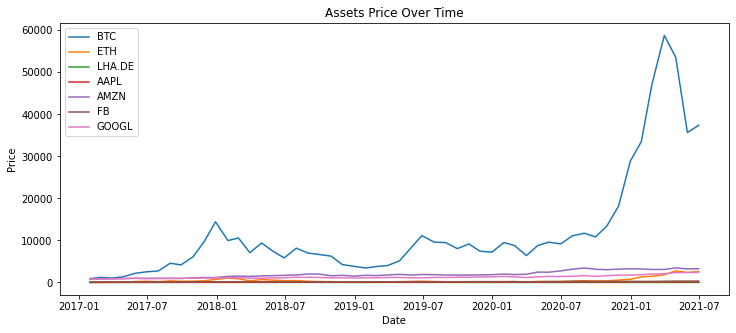

In [4]:
def plot_prices(finance_data_monthly):
 
    plt.figure(figsize=(12,5))
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Assets Price Over Time")

    coins = list(finance_data_monthly.keys())
    print(coins)
    for coin in coins:
        #coins.plot()
        #finance_data_monthly[coin].plot()
   #     display(coin,finance_data_monthly[coin])
        plt.plot(finance_data_monthly[coin].index,finance_data_monthly[coin].price)
        
    plt.legend(coins)
    plt.show()
  #  display(finance_data_monthly['BTC'])


plot_prices(monthly_data_coll_sync)        



### 4. Calculate and plot the monthly simple rate of return over time.
Plot that shows the daily simple rate of return for coins over time. 

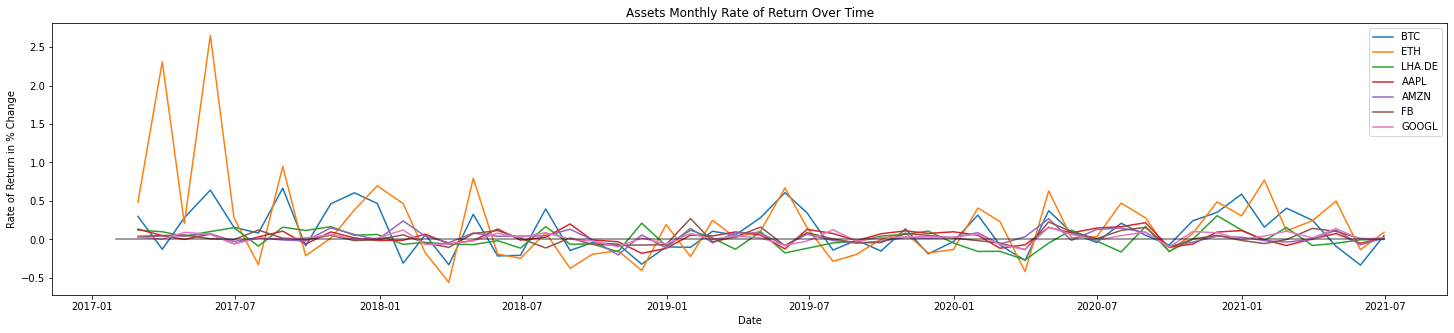

In [5]:
def render_monthly_return(finance_data_monthly):
    
    plt.figure(figsize=(25,5))
    plt.xlabel("Date")
    plt.ylabel("Rate of Return in % Change")
    plt.title("Assets Monthly Rate of Return Over Time")
 #   ax1 = plt.subplot()
  


    coins = list(finance_data_monthly.keys())
    for coin in coins:
        plt.plot(finance_data_monthly[coin].index,finance_data_monthly[coin].pct_change())
    plt.legend(coins)
    reference_line_simple = [0 for i in finance_data_monthly[coins[1]].index]
   # print(finance_data_monthly[coins[0]].index)
    plt.plot(finance_data_monthly[coins[0]].index,reference_line_simple,color = 'black',alpha = 0.5)

 #   ax1.set_xticks(range(len(finance_data_monthly[coins[0]].price)))
#    ax1.set_xticklabels(finance_data_monthly[coins[0]].index)
        
    plt.show()

        
render_monthly_return(monthly_data_coll_sync)      

  



### 5. Plots of daily simple rate of return of last days.
In order to better visualize the daily returns

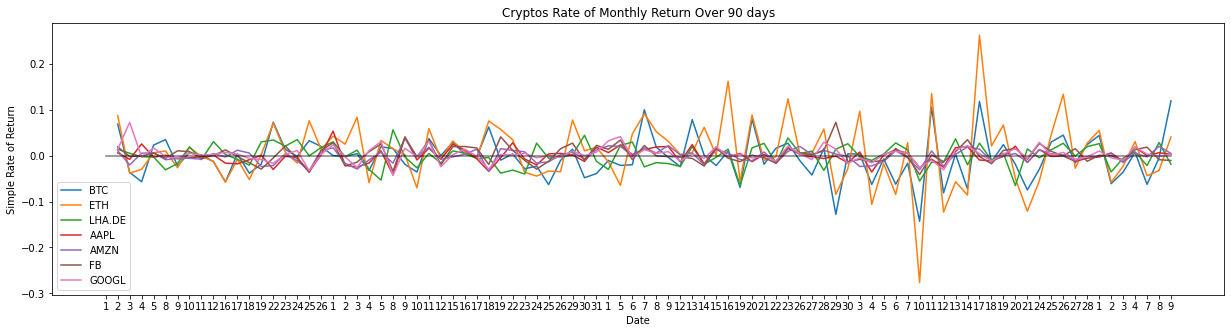

In [6]:
def display_monthly_return_current_days(finance_data_daily,finance_data_monthly,days=90):
    
    plt.figure(figsize=(21,5))
    plt.xlabel("Date")
    plt.ylabel("Simple Rate of Return")
    plt.title("Cryptos Rate of Monthly Return Over {} days".format(days) )
   

    coins = list(finance_data_daily.keys())
 #   fig = plt.figure(figsize=(15,15))
   # ax1 = fig.add_subplot(211)
    for coin in coins:      
        length = finance_data_daily[coin].index.size
        shortened_finance_data = finance_data_daily[coin].iloc[length - days : length].reset_index()
        x = shortened_finance_data.index
        y = shortened_finance_data.price.pct_change()
      #  ax1.plot(shortened_finance_data)
        plt.plot(x,y)
        
    plt.legend(coins)
    reference_line_simple = [0 for i in range(days)]
    plt.plot(range(days),reference_line_simple,color = 'black',alpha = 0.5)
    ax1 = plt.subplot()
    ax1.set_xticks(range(days))
   # display(shortened_finance_data)

    ax1.set_xticklabels(shortened_finance_data.Date.dt.day)
  
    plt.show()

        
display_monthly_return_current_days(daily_data_coll,monthly_data_coll_sync)     

### 6.Plot of the mean monthly simple rate of return

#### Step 1: Calculate mean rate of return
For each coin, monthly mean rate of return is an indicator for profitability.


Monthly mean from 2017-02-28 to 2021-06-30:
ETH has the highest mean simple rate of return over the period of data collected.
Thus ETH would have been a good choice for investment over this period of time. LHA.DE, on the other hand,
has the lowest mean simple rate of return over the period.


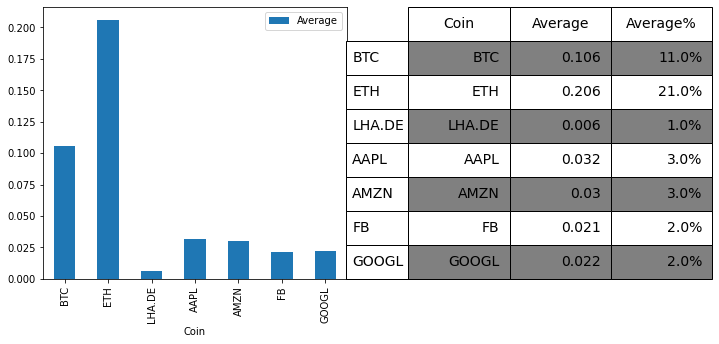

In [7]:
def calc_mean(finance_data_monthly):  # calculate monthly mean  
    coins = list(finance_data_monthly.keys())  
    coins_mean = {}
    for coin in coins:        
        monthly_mean = float(finance_data_monthly[coin].pct_change().mean())
        coins_mean[coin] = monthly_mean
    return coins_mean
        
def find_min_of_dict(means): #find the minimum value of the means
    myDict_values = list( means.values() )
    myDict_keys = list( means.keys() )
    min_value = min( myDict_values )
    return myDict_keys[ myDict_values.index( min_value ) ]
      
      
monthly_mean = calc_mean(monthly_data_coll)
min_monthly_mean = find_min_of_dict(monthly_mean)
max_monthly_mean = max(monthly_mean, key=monthly_mean.get)
monthly_mean_df = pd.DataFrame(list(monthly_mean.items()), index=range(len(monthly_mean)),columns=['Coin','Average'])
mr = monthly_data_coll_sync
begin = str((mr[list(mr.keys())[0]]).index[1])[0:10]
end = str((mr[list(mr.keys())[0]]).index[((mr[list(mr.keys())[0]]).index.size -1)])[0:10]
print('Monthly mean from {} to {}:'.format(begin,end))
monthly_mean_df['Average%'] = monthly_mean_df['Average'].round(decimals=2).apply(lambda x: str((x*100))+'%')
monthly_mean_df['Average'] = monthly_mean_df['Average'].round(decimals=3) #Rundung zur besseren Table darstellung

def draw_coin_bar(value_dict,ylabel='Monthly_mean',xlabel='Coins',title="Monthly mean rate of return"):
     # grab each daily mean value for the y axis
    height = []
    for key in value_dict.keys(): height.append(value_dict[key])
    
    # arrange keys on x axis based on length
    x_pos = np.arange(len(value_dict.keys()))
    # plot bars
    plt.bar(x_pos , height)
 
   # create names on the x-axis
    plt.xticks(x_pos, value_dict.keys())

   # label chart
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # show graphic
    plt.show()

def create_tablecell_colors(df_table): #um die Farben der Tabelle zu wechseln
    col_length = len(df_table.columns)
    row_length = df_table.index.size
    cw = ['white' for i in range(col_length)]
    cg = ['grey' for i in range(col_length)]  
    cc = []
    j = 1
    for i in range(row_length):
        if j % 2 == 0:
            cc.append(cw)
        else:
            cc.append(cg)
        j+=1
    return cc

    
#die plots kommen alle in eine Zeile inklusive der Table
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
#monthly_mean = pd.DataFrame(monthly_mean)
monthly_mean_df.plot(ax=axes[0],x='Coin',y='Average',kind='bar')
#table as plot als workaround
axes[1].axis('off')
bbox=[0, 0, 1, 1]
table = axes[1].table(cellText = monthly_mean_df.values, rowLabels = monthly_mean_df.Coin, bbox=bbox,
                          colLabels=monthly_mean_df.columns,colWidths=[9.3 for x in monthly_mean_df.columns],
                          cellColours=create_tablecell_colors(monthly_mean_df))
table.auto_set_font_size(True)
font_size = 14
table.set_fontsize(font_size)
#draw_coin_bar(monthly_mean)    

string = '''{} has the highest mean simple rate of return over the period of data collected.
Thus {} would have been a good choice for investment over this period of time. {}, on the other hand,
has the lowest mean simple rate of return over the period.'''.format(max_monthly_mean ,max_monthly_mean,min_monthly_mean)
print(string)


### 7. Calculate and plot the variance.

#### Step 1: Variance & Standard Deviation
Volatility ist calculated by Variance and Standard Deviation of Rate of Returs


Monthly Volatility from 2017-02-28 to 2021-06-30:
ETH has the highest variance over the period of data collected.
Thus ETH would have been a bad choice for investment over this period of time. GOOGL, on the other hand,
has the lowest variance over the period.


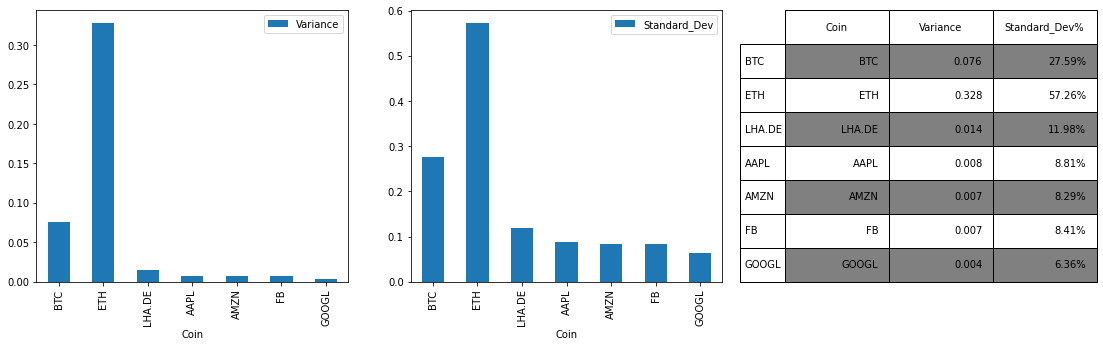

In [8]:
def calc_var(finance_data):  # calculate variance  und Std
    coins = list(finance_data.keys())
    coins_stat = {'Coin':[],'Variance':[],'Standard_Dev':[]}  
    for coin in coins: 
        rate_of_returns = finance_data[coin].price.pct_change()
        var = rate_of_returns.var() #diese funktion ziegt die monthly returns
        std = rate_of_returns.std() #diese funktion ziegt die monthly returns
        
        coins_stat['Coin'].append(coin)
        coins_stat['Variance'].append(var)
        coins_stat['Standard_Dev'].append(std)         
    return coins_stat

def create_tablecell_colors(df_table): #um die Farben der Tabelle zu wechseln
    col_length = len(df_table.columns)
    row_length = df_table.index.size
    cw = ['white' for i in range(col_length)]
    cg = ['grey' for i in range(col_length)]  
    cc = []
    j = 1
    for i in range(row_length):
        if j % 2 == 0:
            cc.append(cw)
        else:
            cc.append(cg)
        j+=1
    return cc

            
monthly_var = calc_var(monthly_data_coll)
monthly_var_df = pd.DataFrame(monthly_var)

min_monthly_var = monthly_var_df.loc[monthly_var_df['Variance'].idxmin()]
max_monthly_var = monthly_var_df.loc[monthly_var_df['Variance'].idxmax()]

print('Monthly Volatility from {} to {}:'.format(begin,end))

#die plots kommen alle in eine Zeile inklusive der Table
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(19,5))
monthly_var_df['Standard_Dev%'] = monthly_var_df['Standard_Dev'].apply(lambda x: str(round(x*100,2))+'%')

monthly_var_df.plot(ax=axes[0],x='Coin',y='Variance',kind='bar')
monthly_var_df.plot(ax=axes[1],x='Coin',y='Standard_Dev',kind='bar')

monthly_var_df = monthly_var_df.round(decimals=3)

monthly_var_df = monthly_var_df.drop(columns=['Standard_Dev'],axis=1)
axes[2].axis('off')
bbox=[0, 0, 1, 1]
table = axes[2].table(cellText = monthly_var_df.values, rowLabels = monthly_var_df.Coin, bbox=bbox,
                          colLabels=monthly_var_df.columns,colWidths=[9.3 for x in monthly_var_df.columns],
                          cellColours=create_tablecell_colors(monthly_var_df))
table.auto_set_font_size(True)
font_size = 14
table.set_fontsize(font_size)


stringi = '''{} has the highest variance over the period of data collected.
Thus {} would have been a bad choice for investment over this period of time. {}, on the other hand,
has the lowest variance over the period.'''.format(max_monthly_var['Coin'],max_monthly_var['Coin'],min_monthly_var['Coin'])
print(stringi)


### 9. Correlations
Correlation of stock pairs show how big the concentration risk is. Correlation of 1 means perfectly aligned, 0 means orthogonal, negative correlation shows contrary development

In [9]:
def create_df_out_of_dic(finance_data,key='price'):  # calculate corr
    coins = list(finance_data.keys())
    returns_pd = pd.DataFrame()
    for coin in coins: 
        returns_pd[coin]=finance_data[coin][key]    
                  
    return returns_pd
df = pd.DataFrame(create_df_out_of_dic(monthly_data_coll_sync).pct_change())

corr = pd.DataFrame(create_df_out_of_dic(monthly_data_coll_sync).pct_change().corr()).round(decimals=3)
display(corr)
#get min and max correlations for display
mc = np.unravel_index(np.argmin(corr.values), corr.shape)
min_corr = corr.iloc[mc]
min_col = corr.columns[mc[1]]
min_row = corr.index[mc[0]]
#get max values besides the 1.o for each pair                     
corr_values = df.corr().unstack().sort_values().drop_duplicates()
max_cori = corr_values.iloc[(corr_values.index.size-2):(corr_values.index.size-1)].reset_index()
max_cori_string = ((max_cori['level_0'].iloc[0]),(max_cori['level_1'].iloc[0]))

string = '''{} and {} are least correlated, while {} and {} exhibit the highest
correlation.'''.format(min_row,min_col,max_cori_string[0],max_cori_string[1])
print(string)

,BTC,ETH,LHA.DE,AAPL,AMZN,FB,GOOGL
BTC,1.000,0.500,0.283,0.202,0.100,0.116,0.161
ETH,0.500,1.000,0.202,0.137,0.177,0.132,0.182
LHA.DE,0.283,0.202,1.000,0.185,0.111,0.216,0.408
AAPL,0.202,0.137,0.185,1.000,0.556,0.570,0.439
AMZN,0.100,0.177,0.111,0.556,1.000,0.595,0.563
FB,0.116,0.132,0.216,0.570,0.595,1.000,0.585
GOOGL,0.161,0.182,0.408,0.439,0.563,0.585,1.000


BTC and AMZN are least correlated, while AMZN and FB exhibit the highest
correlation.


### Efficient Frontier
Portfolio optimization by finding the optimal curve in regard to max profitability vs. min volatility. 

 - According to MPT Portfolio with the weights ['BTC:0.0', 'ETH:1.0', 'LHA.DE:0.0', 'AAPL:0.0', 'AMZN:0.0', 'FB:0.0', 'GOOGL:0.0'] has the highest ratio of returns over variance.
 - The best risk/profit ratio according to Sharpe ration is Portfolio with weights:
 BTC Weight       0.212270
ETH Weight       0.100897
LHA.DE Weight    0.002599
AAPL Weight      0.264798
AMZN Weight      0.197428
FB Weight        0.035339
GOOGL Weight     0.186669
Name: 4550, dtype: float64
 
 - Lowest Risk portfolio is weighted: 
 BTC Weight       0.004572
ETH Weight       0.002963
LHA.DE Weight    0.143660
AAPL Weight      0.077750
AMZN Weight      0.283730
FB Weight        0.178983
GOOGL Weight     0.308341
Name: 2582, dtype: float64)


<Figure size 1440x720 with 0 Axes>

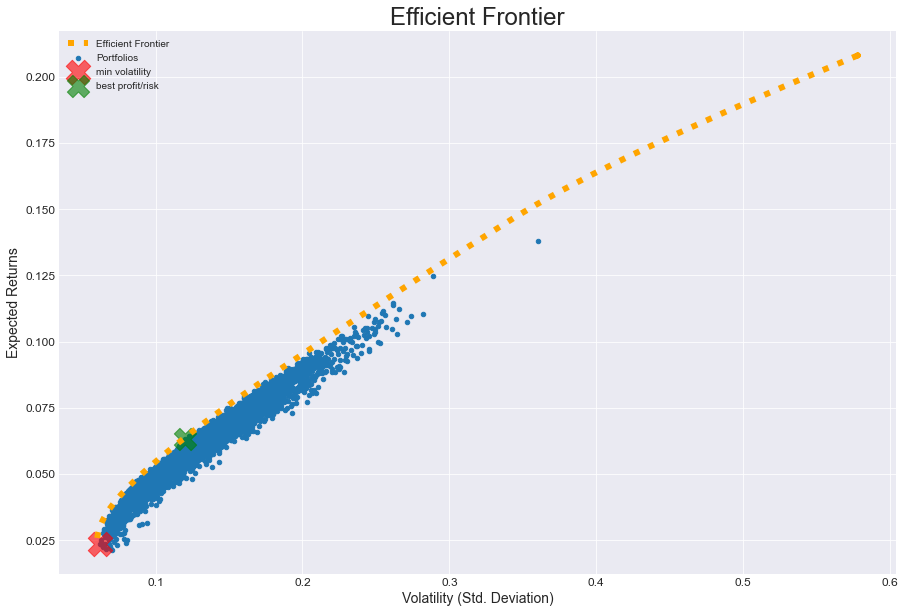

In [10]:
import cvxopt as opt
from cvxopt import blas, solvers
import mpld3
from mpld3 import plugins

# Turn off progress printing 
solvers.options['show_progress'] = False

def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order] 
    return df


def optimal_portfolio_ca(returns):
    n = returns.shape[1]
    #returns = np.transpose(returns.as_matrix())
    returns = np.transpose(returns.to_numpy())


    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

def print_result(weight_result_st,risky_weights,norisk_weights):
    # 8. Plot the set of portfolios on the EF
    result_string = ''' - According to MPT Portfolio with the weights {} has the highest ratio of returns over variance.
 - The best risk/profit ratio according to Sharpe ration is Portfolio with weights:
 {}
 
 - Lowest Risk portfolio is weighted: 
 {})'''.format(weight_result_st,risky_weights,norisk_weights)
    print(result_string)


def get_random_portfolios(data_coll):
    # 1. Load the stock data
    #stock_data = pd.read_csv('weak.txt')
    stock_data = create_df_out_of_dic(data_coll)
    stock_data.insert(loc=0,column='placeholder',value='place')
    selected = list(stock_data.columns[1:])
   # print('sel',selected)
    # 2. Find the return for each period
    returns = stock_data[selected].pct_change()
    returns = returns[1:(returns.index.size-1)] #get rid of NAN and 0
    # 3. Find the expected returns 
    expected_returns = returns.mean()
    # 4. Find the covariance 
    cov = returns.cov()
    # 5. Find a set of random portfolios
    return return_portfolios(expected_returns ,cov),returns,selected,expected_returns,cov


def display_random_portfolios(random_portfolios):
    # 6. Plot the set of random portfolios
    plt.figure(figsize=(20,10))
    plt.style.use('seaborn-dark')
    random_portfolios.plot.scatter(x='Volatility',y='Returns',fontsize=12,figsize=(15,10),grid=True)
    
def get_optimal_portfolio(returns,selected_assets):
     
    opt_weights,ef_returns,ef_risks = optimal_portfolio_ca(returns)
    opt_weights_list = opt_weights.flatten().tolist()
    opt_weights_result_st=[]
    for i in range(len(selected_assets)): opt_weights_result_st.append(str(selected_assets[i] +':' + str(np.round(opt_weights_list[i]))))
    return opt_weights_result_st,ef_returns,ef_risks

def display_optimal_portfolio(risk,returns,min_vol_port,optimal_risky_port):
    plt.ylabel('Expected Returns',fontsize=14)
    plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
    plt.title('Efficient Frontier', fontsize=24)
    plt.plot(risks,returns,color='orange',linestyle='dotted',linewidth=6)
    #plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    #print(cov)
    #single_asset_std=np.sqrt(np.diagonal(cov))
    plt.scatter(min_vol_port['Volatility'],min_vol_port['Returns'],marker='X',color='red',s=600,alpha=.6)
    plt.scatter(optimal_risky_port['Volatility'],optimal_risky_port['Returns'],marker='X',color='green',s=500,alpha=.6)
    plt.legend(['Efficient Frontier','Portfolios','min volatility','best profit/risk '])

    
        
random_portfolios,returns,selected_assets,expected_returns,cov = get_random_portfolios(monthly_data_coll_sync) 
display_random_portfolios(random_portfolios)  
# Finding the optimal portfolio
optimal_portfolio,returns,risks = get_optimal_portfolio(returns,selected_assets)

#find min risk portfolio
min_vol_port = random_portfolios.iloc[random_portfolios['Volatility'].idxmin()]
norisk_weights = min_vol_port.iloc[2:min_vol_port.index.size]
# idxmin() gives us the minimum value in the column specified.                               
rf = 0.01 # risk factor
optimal_risky_port = random_portfolios.iloc[((random_portfolios['Returns']-rf)/random_portfolios['Volatility']).idxmax()]
risky_weights = optimal_risky_port.iloc[2:optimal_risky_port.index.size]
print_result(optimal_portfolio,risky_weights,norisk_weights)

display_optimal_portfolio(risks,returns,min_vol_port,optimal_risky_port)

#plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)


# Compare the set of portfolios on the EF to the 
try:
  single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
 # display(single_asset)
  plt.scatter(min_vol_port['Volatility'],min_vol_port['Returns'],marker='X',color='red',s=200,alpha=.6)
except:
  pass
plt.show()


### Efficient Frontier II
On the interactive chart, one can explore different portfolio weighting on the efficient frontier

In [11]:
def interactive_plot(risks, returns, portfolios):
   
    plt.figure(figsize=(20,20))
   
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
    ax.grid(True, alpha=0.3)


    labels = []
    for i in range(len(risks)):
        rounds = np.round(portfolios[i],decimals=1)# map(lambda x: round(x,3), portfolios[i])
       # rounds = map(lambda x: round(x,3), portfolios[i])
        label = " Risk: " + str(risks[i]) + "<br>" + " Return: " + str(returns[i])  + "<br>" + " Portfolio Weights: " + str(rounds)
        labels.append(str(label))

    points = ax.plot(risks, returns,'y-o',
                     mec='k', ms=15, mew=1, alpha=.6)# color='b',    
    fig.figsize=(20,20)
    ax.set_xlabel('standard deviation')
    ax.set_ylabel('return')
    ax.set_title('Efficient Frontier Weighting  {}'.format(selected_assets), size=20)

    tooltip = plugins.PointHTMLTooltip(points[0], labels,
                                   voffset=10, hoffset=10)
    plugins.connect(fig, tooltip)

    return mpld3.display()

def convert_portfolios(portfolios):
    ''' Takes in a cvxopt matrix of portfolios, returns a list of portfolios '''
    port_list = []
    for portfolio in portfolios:
        temp = np.array(portfolio).T
        port_list.append(temp[0].tolist())
        
    return port_list

    
def covmean_portfolio(covariances, mean_returns):
    ''' Returns an optimal portfolio given a covariance matrix and matrix of mean returns '''
    n = len(mean_returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]


    S = opt.matrix(covariances)  # convert array to matrix  

    pbar = opt.matrix(mean_returns)  # convert array to matrix

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    #Convert portfolios to list for output
    port_list = convert_portfolios(portfolios)
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    frontier_returns = [blas.dot(pbar, x) for x in portfolios]  #differ from those input, renamed
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios] #np.sqrt returns the stdev, not variance
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(frontier_returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']   

    return np.asarray(wt), frontier_returns, risks, port_list

weights2,returns2,risks2,pfs = covmean_portfolio(np.array(cov),expected_returns)
interactive_plot(risks2, returns2, pfs)

<Figure size 1440x1440 with 0 Axes>